In [1]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from IPython.display import display
import xgboost as xgb

In [3]:
df = pd.read_csv('housing.csv')
df = df[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]
df = df.fillna(0)
# Splitting the data into train/val/test sets
train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
# Applying the log transformation to the 'median_house_value' variable
train['median_house_value'] = np.log1p(train['median_house_value'])
val['median_house_value'] = np.log1p(val['median_house_value'])
test['median_house_value'] = np.log1p(test['median_house_value'])
# Creating Dependent Variables
y_train = train.median_house_value.values
y_val = val.median_house_value.values
y_test = test.median_house_value.values
# Deleting target column i.e. above_average from training datasets
del train['median_house_value']
del val['median_house_value']
del test['median_house_value']
# Print the proportions of the 3 datasets to the original df
print(f"Proportion of train set: {len(train)/len(df)}")
print(f"Proportion of validation set: {len(val)/len(df)}")
print(f"Proportion of test set: {len(test)/len(df)}")

Proportion of train set: 0.5999235035379614
Proportion of validation set: 0.20003824823101932
Proportion of test set: 0.20003824823101932


In [4]:
dv = DictVectorizer(sparse=True)                              
train_dict = train.to_dict(orient='records') 
X_train = dv.fit_transform(train_dict)
val_dict = val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [5]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [6]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
print(round(score, 3))

0.245


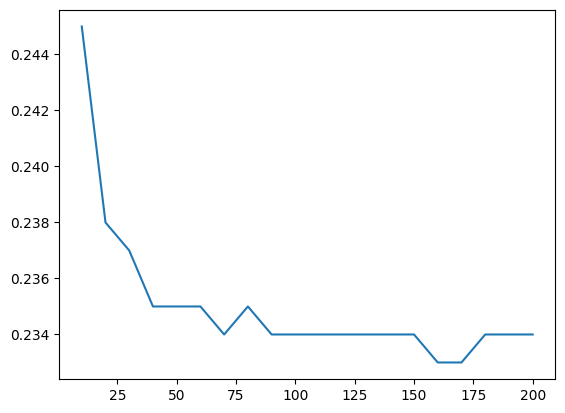

In [8]:
scores = []
for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    score = round(score, 3)
    scores.append((i, score))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])
plt.plot(df_scores.n_estimators, df_scores.score)

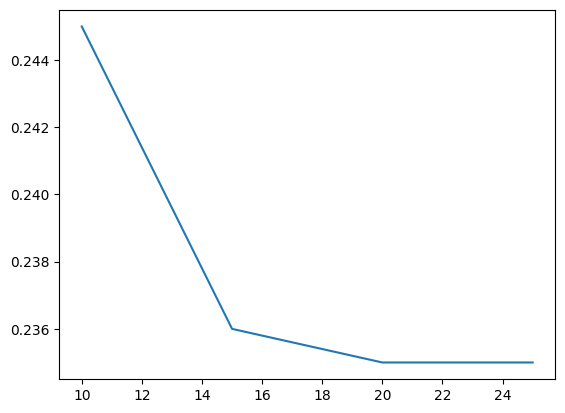

In [10]:
max_depth_scores = []
for i in [10, 15, 20, 25]:
    scores = []
    for j in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=i, n_estimators=j, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append(score)
    mean_score = round(np.mean(scores), 3)
    max_depth_scores.append((i, mean_score))
df_scores = pd.DataFrame(max_depth_scores, columns=['max_depth', 'score'])
plt.plot(df_scores.max_depth, df_scores.score)

In [11]:
df_scores

,max_depth,score
0,10,0.245
1,15,0.236
2,20,0.235
3,25,0.235


In [13]:
# Fit the model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Get feature names
feature_names = dv.get_feature_names_out()

# Create a dictionary mapping feature names to their importances
feature_importances = dict(zip(feature_names, importances))

# Print the feature importances
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

# To find the most important feature
most_important_feature = max(feature_importances, key=feature_importances.get)
print(f"The most important feature is {most_important_feature}")


households: 0.014953476344031812
housing_median_age: 0.030194348002947978
latitude: 0.10189141894557846
longitude: 0.08617580381806568
median_income: 0.33566849340251753
ocean_proximity=<1H OCEAN: 0.29247296545343116
ocean_proximity=INLAND: 0.07380644294557998
population: 0.026820690830484637
total_bedrooms: 0.01624480660362488
total_rooms: 0.021771553653737723
The most important feature is median_income


In [35]:
# Replace '<' and '=' with '_'
features = [feat.replace('<', '_').replace('=', '_') for feat in dv.get_feature_names_out()]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [36]:
%%capture output
#We use this to capture what is printed out when we train the XGBoost model. 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

# verbose_eval = increments of n, whereby n is what is stated.

In [37]:
s = output.stdout
print(s[:100])

[0]	train-rmse:0.44350	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463
[10]	train-rmse:0.21


In [38]:
# Function for producing a dataframe
def parse_xgb_output(output, val_col_name='val_rmse_03'):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', val_col_name]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

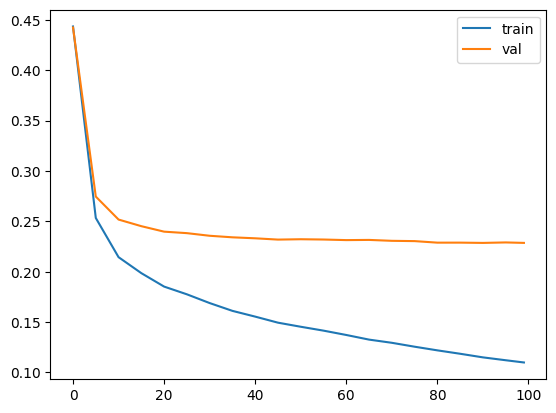

In [39]:
df_score = parse_xgb_output(output)
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse_03, label='val')
plt.legend()

In [40]:
%%capture output
#We use this to capture what is printed out when we train the XGBoost model. 

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

# verbose_eval = increments of n, whereby n is what is stated.

In [41]:
s = output.stdout
print(s[:100])

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37822	val-rmse:0.38151
[10]	train-rmse:0.30


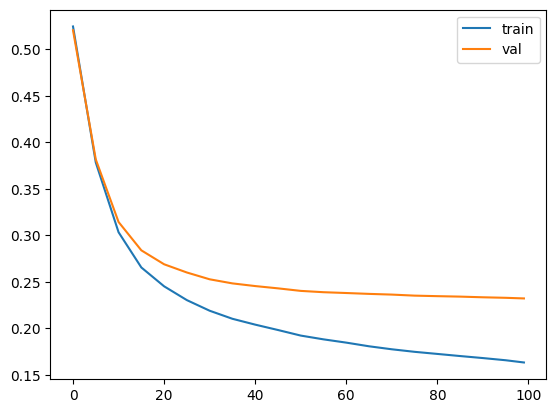

In [42]:
df_score_2 = parse_xgb_output(output, 'val_rmse_01')
plt.plot(df_score_2.num_iter, df_score_2.train_rmse, label='train')
plt.plot(df_score_2.num_iter, df_score_2.val_rmse_01, label='val')
plt.legend()

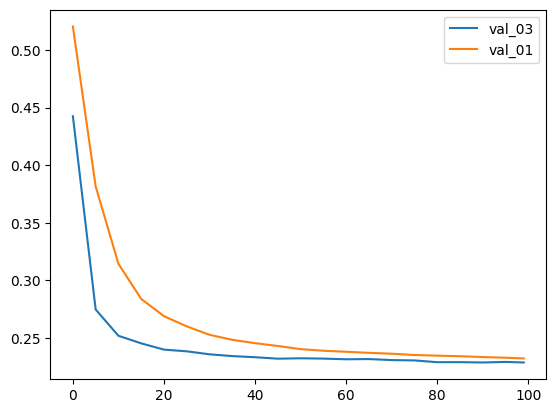

In [43]:
merged_df_score = pd.merge(df_score[['num_iter', 'val_rmse_03']],
                           df_score_2[['num_iter', 'val_rmse_01']],
                           on='num_iter'
                          )
plt.plot(merged_df_score.num_iter, merged_df_score.val_rmse_03, label='val_03')
plt.plot(merged_df_score.num_iter, merged_df_score.val_rmse_01, label='val_01')
plt.legend()

In [44]:
merged_df_score

,num_iter,val_rmse_03,val_rmse_01
0,0,0.44250,0.52045
1,5,0.27463,0.38151
2,10,0.25179,0.31427
3,15,0.24522,0.28380
4,20,0.23978,0.26882
5,25,0.23830,0.25997
6,30,0.23570,0.25266
7,35,0.23416,0.24826
8,40,0.23318,0.24539
9,45,0.23190,0.24293
